In [1]:
import pandas as pd 
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
import nltk
from nltk.corpus import stopwords
import time

# Display all columns for DataFrame printouts. 
pd.set_option('display.max_columns', None)

# Predicting genre using audio characteristics

Let's see if we are able to predict the genres of songs in our dataset using the different audio features of tracks that were identified by Spotify, like "loudness" or "danceability."

We'll start by importing our .csv data into pandas. We can drop popularity, because hypothetically if we are seeing a song for the first time it is unlikely that we'll know the popularity rating.

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# path = '/content/gdrive/MyDrive/audio_features_5.1_clean.csv'
# tracks = pd.read_csv(path)

In [4]:
tracks = pd.read_csv('data/audio_features_5.3_clean.csv')
tracks = tracks.drop(['popularity'], axis=1)

seed = 538

In [5]:
# tracks = tracks.sample(random_state=seed, n=10000)

To make our prediction task more managable, we'll focus on predicting the genres that most frequently occur in our dataset.

In [6]:
N_TOP_GENRES = 10

selected_genres = list(tracks.groupby(by='genre') \
                       .size() \
                       .sort_values(ascending=False) \
                       .head(N_TOP_GENRES) \
                       .index
                       )

tracks = tracks[tracks.genre.isin(selected_genres)]

## Initial visualization

We'll perform some initial visualizations to get a better sense of our data.

So that we can see the coorelation between our features and genre, we'll encode genre with label encoder.

In [7]:
# Encode genre with label encoder.
label_enc = LabelEncoder()
tracks_enc = tracks.copy(deep=True)
tracks_enc[tracks_enc.columns[15]] = label_enc.fit_transform(tracks_enc.genre)

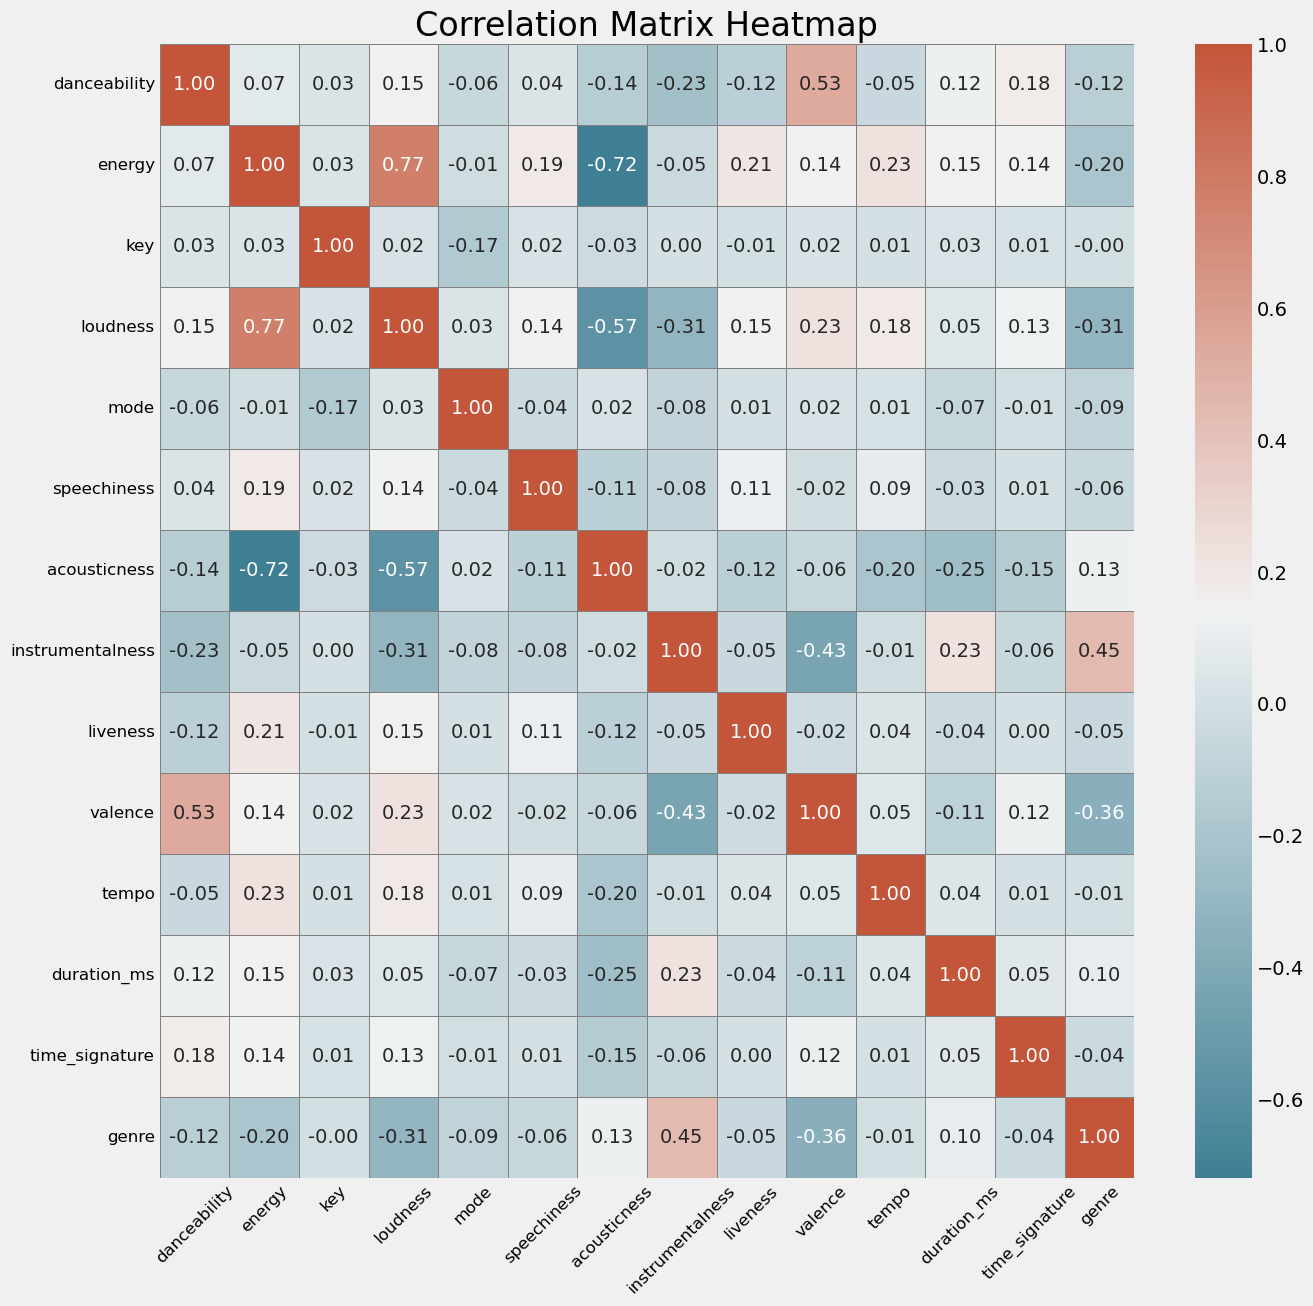

In [8]:
# Coorelation matrix heatmap.
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(14, 14))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tracks_enc.corr(), annot=True, fmt='.2f', cmap=cmap, linewidths=0.5, linecolor='gray')
plt.title("Correlation Matrix Heatmap", fontsize=24)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Overall, there is high colinearity between some features, and a reasonably strong relationship between some of our features and genre.

Because our features are not independent given the class label, we will likely not get good performance withi certain classifiers like Naive Bayes that rely on independence.


Let's also check the distribution of our features.

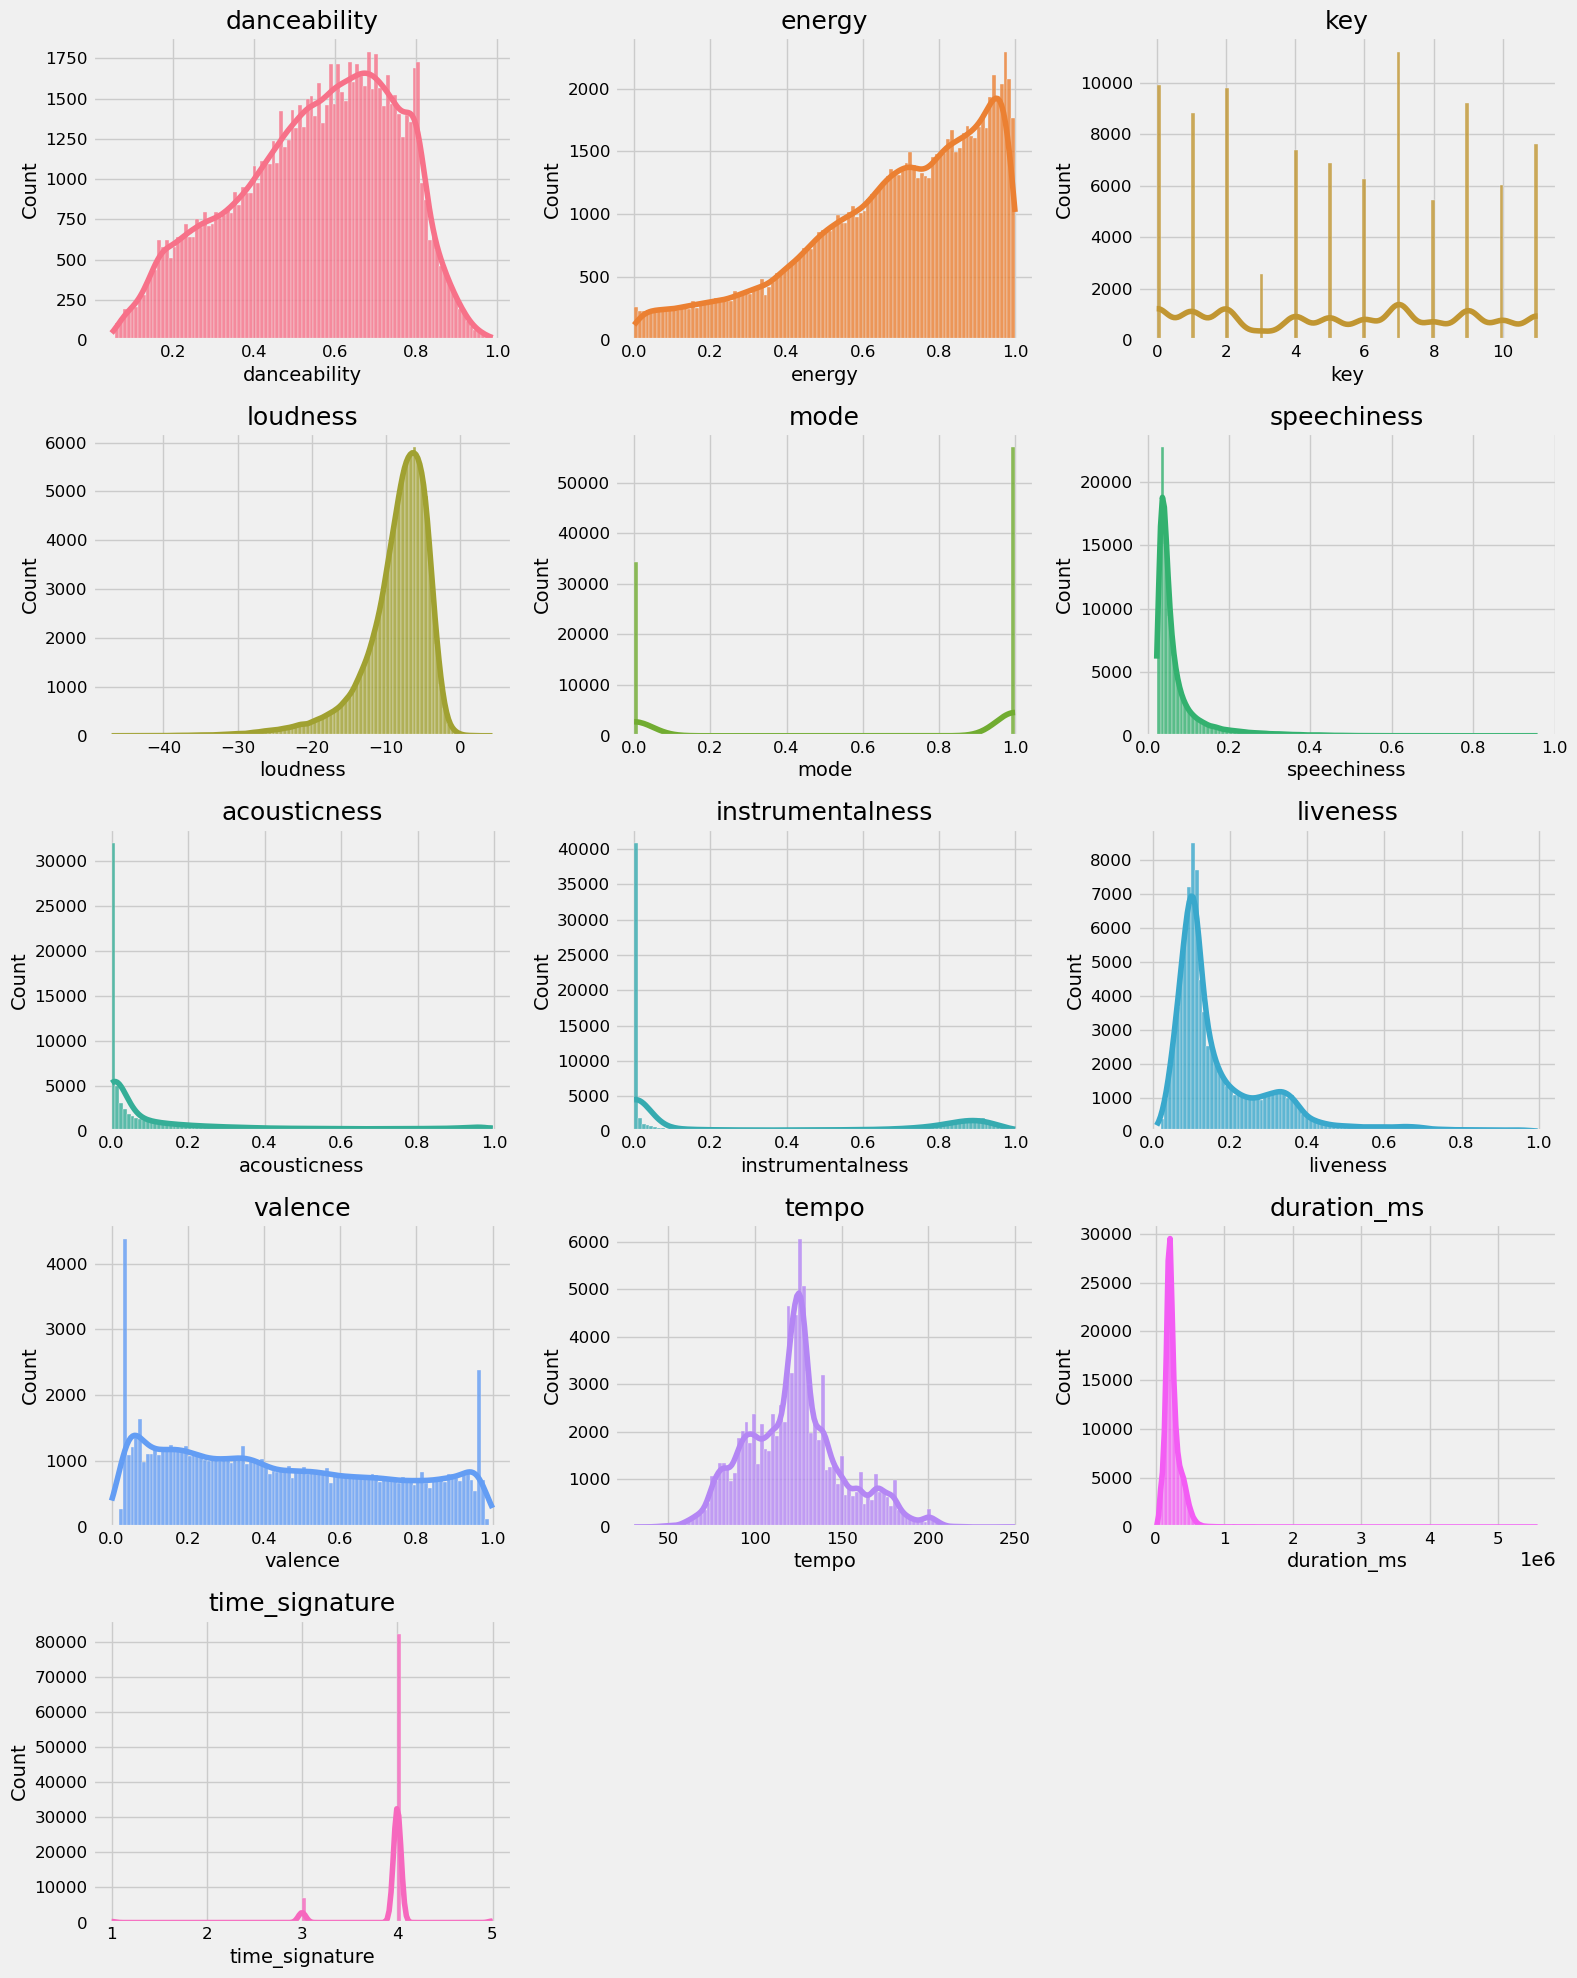

In [9]:
cols = tracks.select_dtypes(include={'int64', 'float64'}).columns
ncols = 3

nrows = (len(cols) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, 
                         ncols=ncols, 
                         figsize=(16, 4 * nrows), 
                         sharey=False)
axes = axes.flatten()

# Set the color palette for the histograms
colors = sns.color_palette('husl', len(cols))

for i, col in enumerate(cols):
    sns.histplot(tracks, 
                 x=col, 
                 bins=100, 
                 ax=axes[i], 
                 color=colors[i], 
                 kde=True, 
                 alpha=0.8)
    axes[i].set_title(col, fontsize=18)
    axes[i].set_xlabel(col, fontsize=14)
    axes[i].set_ylabel('Count', fontsize=14)
    axes[i].tick_params(axis='both', labelsize=12)

for i in range(len(cols), nrows * ncols):
    fig.delaxes(axes[i])

fig.tight_layout()
plt.show()

Based on these plots, we can see that energy, loudness, and liveness are moderately skewed. Speechiness, acousticness, and instrumentalness are even more skewed. Valence is roughly uniformly distributed, with some clustering at both extremes.

Because some of our features are skewed and not normally-distributed, we'll have to use techniques that are robust to these distributions. Furthermore, we should keep in mind that, as we established in the previous data cleaning notebook, some of our features have significant numbers of outliers.

Let's also look at class imbalance, which is another important consideration when modeling.

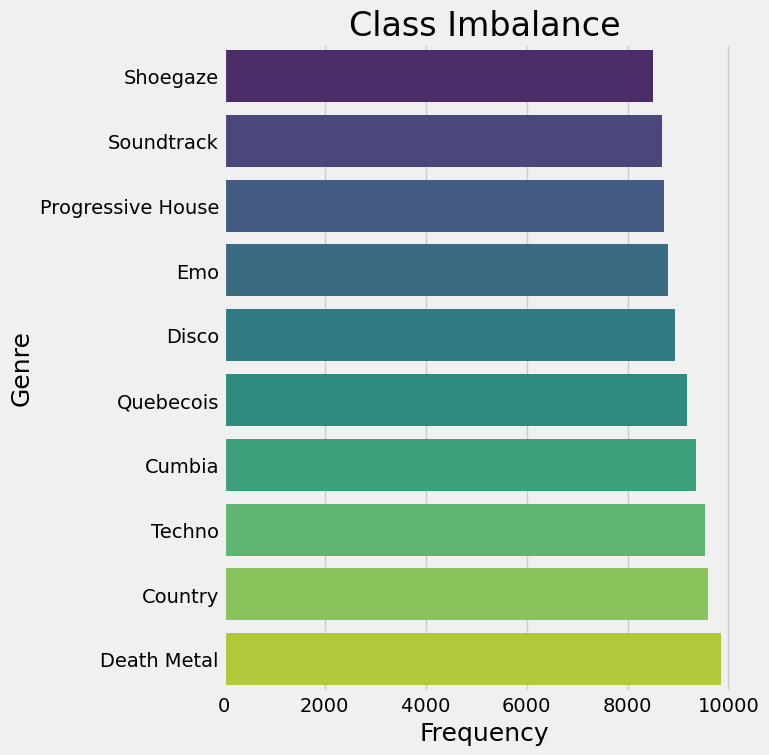

In [10]:
class_counts = tracks['genre'].value_counts()\
                            .sort_values(ascending=True)

plt.figure(figsize=(6, 8))
color_palette = sns.color_palette("viridis", 
                                  n_colors=len(class_counts))
sns.barplot(x=class_counts.values,
            y=class_counts.index,
            orient='h',
            palette=color_palette)
plt.xlabel('Frequency', fontsize=18)
plt.ylabel('Genre', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Class Imbalance', fontsize=24)

plt.show()

Overall, there is good balance between our classes, which will make our classification task easier.

## Feature engineering

We'll start by encoding genre so that we can use it in our classification models.

In [11]:
genre_encoder = LabelEncoder()
tracks[tracks.columns[15]] = genre_encoder.fit_transform(tracks.genre)

Our data contains textual features which may make it easier to separate out different genres. In particular, we have song name and artist name for each track. Because artist name is more likely to be a short (and unique), we'll focus on song name.

We'll need to transform this data so that our different classification models can utalize it.

First, we'll create a new column in our DataFrame with the lowercase data and with non-words and non-spaces removed.

In [12]:
tracks['cleaned_song_name'] = tracks['song_name'].str \
                                                .lower() \
                                                .str \
                                                .replace('[^\w\s]', '')

C:\Users\jackv\AppData\Local\Temp\ipykernel_15552\2470466803.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  tracks['cleaned_song_name'] = tracks['song_name'].str \


To avoid data leakage, we need to perform a train test split at this point before performing feature selection with the text features. 

In [13]:
# Drop the target, the track id, and the text columns we're not using.
X = tracks.drop(['genre',
                 'song_name',
                 'artist_name',
                 'spotify_track_id'], axis=1)
y = tracks.genre

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, 
                                                    random_state=seed)

Next, we'll create a matrix of TF-IDF values, which combines the frequency of a word in a given document compared to its uniqueness across all the given song names.

We'll leave in stopwords for now. It seems possible that some genres may have systematically more of some kinds of stopwords (for example, if the genre has longer or more complex titles). Also, we have a few genres in our dataset from predominantly non-Anglophone regions, so stopwords may help our model distinguish between genres with different primary languages.

In [14]:
# nltk.download('stopwords')
# combined_stopwords_list = stopwords.words('english') + stopwords.words('french') + stopwords.words('spanish')

vectorizer = TfidfVectorizer(stop_words='english')
X_text_train = vectorizer.fit_transform(X_train['cleaned_song_name']);

Because we can't train our model using every unique word (for computational reasons), we'll find a few top words in each genre and use those as new features. 

To separate out our features, we'll use Multinomial Naive Bayes, which is efficient for large datasets and will allow us to find the words that create the most separation between our genres.

We'll train the MNB classifier as a baseline, and then use .feature_log_prob_ to get the probability that a feature is present given that a certain genre.

In [15]:
mnb = MultinomialNB().fit(X_text_train, y_train)

N_FEATURES = 10

genres = genre_encoder.classes_

feature_names = np.array(vectorizer.get_feature_names_out())
top_features_list = []
top_features_by_genre = {}
for i, genre in enumerate(genres):
    top_n = np.argsort(mnb.feature_log_prob_[i])[-N_FEATURES:]
    top_features_list.extend(feature_names[top_n])
    top_features_by_genre[genre] = feature_names[top_n]

Using that code, we were able to get a list of the most important words in our dataset, both sorted by genre and all together in a list.

We'll use the top_features_by_genre for visualization purposes, and top_features_list for our new features.

Let's look at the words identified by our MNB model as being the most important. We will also get the proportions of each word in each genre so we can see how likely it is that our models will encounter a given word.

In [16]:
def calculate_word_proportions(df, word_dict, genre_encoder):
    df = df.copy(deep=True)
    df.genre = genre_encoder.inverse_transform(df.genre)
    proportions = {}
    for genre, words in word_dict.items():
        genre_df = df[df['genre'] == genre]
        genre_word_proportions = {}
        for word in words:
            count = genre_df['song_name'].apply(lambda x: word.lower() in x.lower()).sum()
            genre_word_proportions[word] = count / len(genre_df)
        proportions[genre] = genre_word_proportions
    return proportions

# Calculate the proportions
word_proportions = calculate_word_proportions(tracks, top_features_by_genre, genre_encoder)

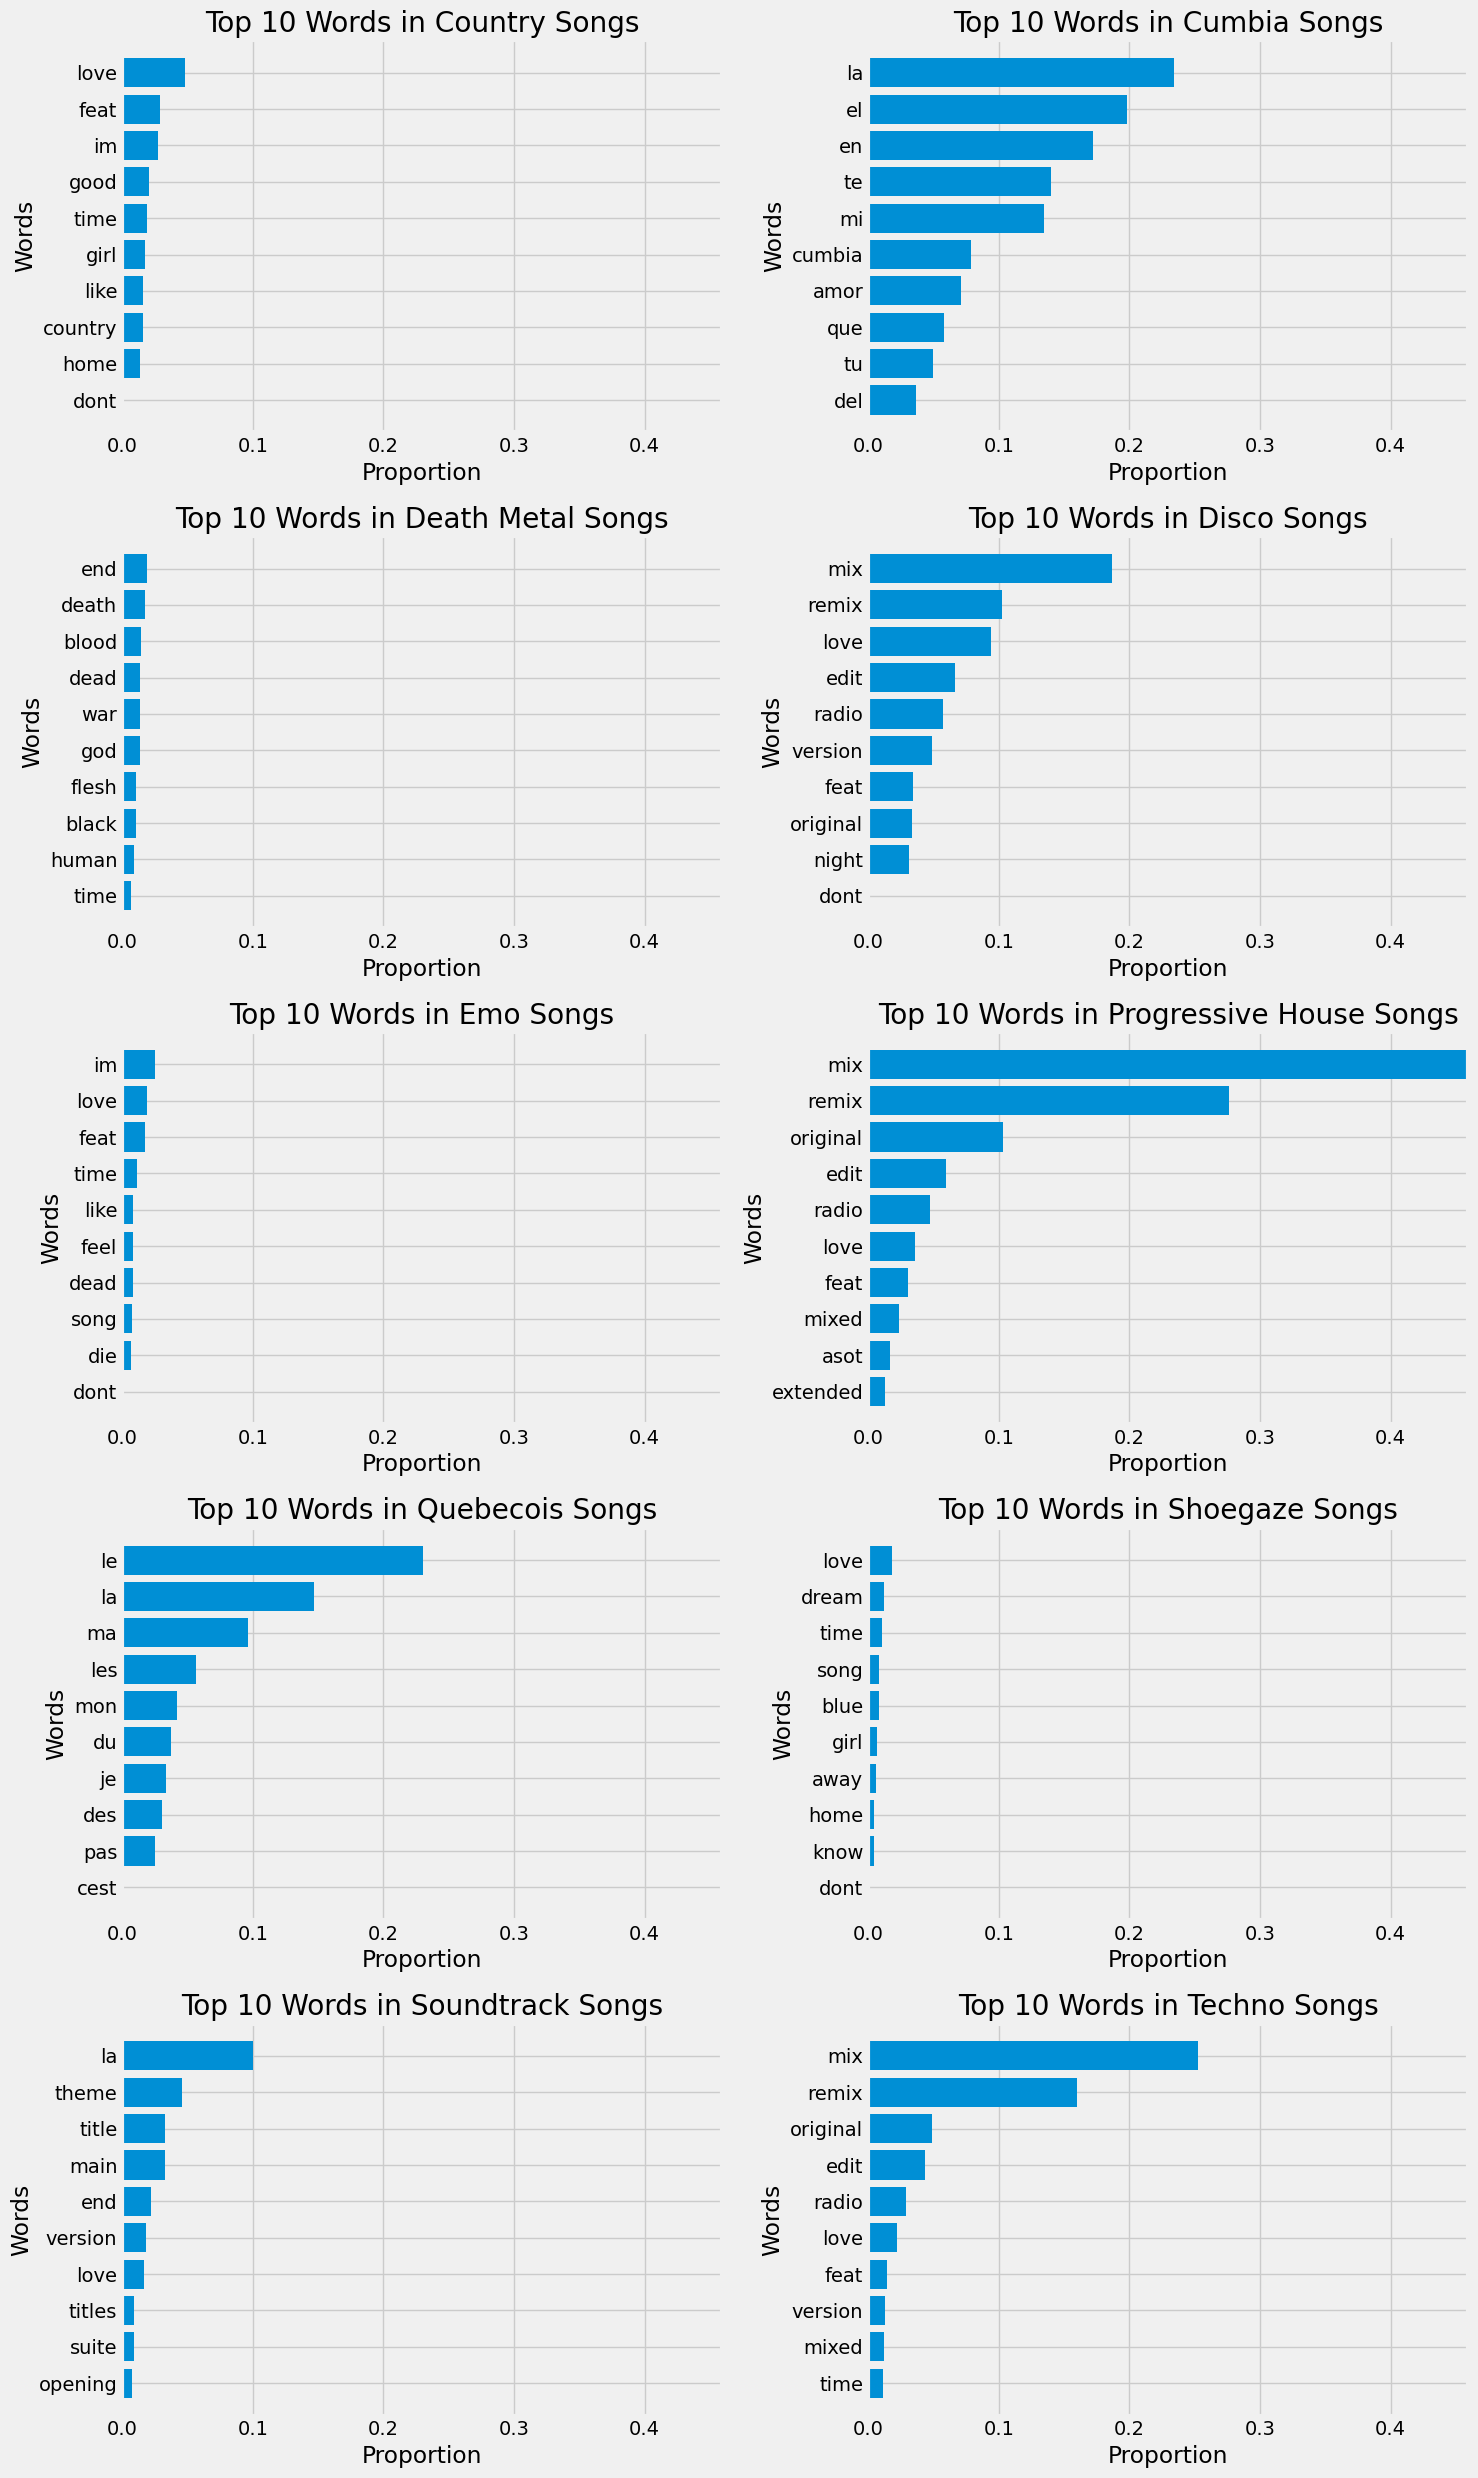

In [17]:
def plot_top_words_all_genres(word_proportions, genres, top_n, ncols=2):
    nrows = (len(genres) + ncols - 1) // ncols

    # Find the maximum proportion value across all genres
    max_proportion = max(max(proportions.values()) for proportions in word_proportions.values())

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5))

    for i, genre in enumerate(genres):
        genre_proportions = word_proportions[genre]
        sorted_items = sorted(genre_proportions.items(), key=lambda x: x[1], reverse=True)
        top_words = sorted_items[:top_n]
        words, proportions = zip(*top_words)

        ax = axes[i // ncols][i % ncols]
        ax.barh(words, proportions)
        ax.set_xlim(0, max_proportion)  # Set the common x-axis limit
        ax.set_xlabel('Proportion')
        ax.set_ylabel('Words')
        ax.set_title(f'Top {top_n} Words in {genre} Songs')
        ax.invert_yaxis()

    # If the number of genres is not a multiple of ncols, remove the extra subplots
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j // ncols][j % ncols])

    plt.tight_layout()
    plt.show()


plot_top_words_all_genres(word_proportions, genre_encoder.classes_, top_n=10)


Unfortunately, there aren't too many words that stand out. There may still be some interesting trends, however. Techno and Disco both have lots of song titles with the word 'mix,' for example. Also, Cumbia and Quebecois have a different set of stopwords in Spanish and French respectively.

Now we'll use concat to add those words as indicator variables to our train and test DataFrames, so we can use them as features.

In [18]:
def create_top_words_df(tracks, words):
    new_columns = []
    for word in words:
      new_column = tracks['cleaned_song_name'].apply(lambda x: 1 if word in x.split() else 0)
      new_columns.append(new_column.rename(word))
    return pd.concat(new_columns, axis=1)

top_words_train = create_top_words_df(X_train, top_features_list)
top_words_test = create_top_words_df(X_test, top_features_list)

X_train = X_train.drop(['cleaned_song_name'], axis=1)
X_test = X_test.drop(['cleaned_song_name'], axis=1)

X_train = pd.concat([X_train, top_words_train], axis=1)
X_test = pd.concat([X_test, top_words_test], axis=1)

Let's split our data into train and test so we can start building an initial classification model as a baseline.

 Now, we will use SMOTE over-sampling to randomly generate new datapoints for the remaining under-represented classes, with the new random points being based on the existing data in those classes.

In [19]:
over_sampler = SMOTE()
X_train_smote, y_train_smote = over_sampler.fit_resample(X_train, y_train)

## K-Nearest Neighbors

Let's start with K-Nearest Neighbors (KNN) as a baseline to see what kind of accuracy we can achieve.

KNN works by looking at our new points and using their proximity to our trainset points to predict the class.

The distance can be calculated in various ways in n-dimensional space (where n is the number of predictors in our dataset).

KNN seems like a good fit for our purposes, as it doesn't make assumption about the underlying distribution of the data, which is good given that our data are not normally distributed.

We'll have to pick our parameters carefully when tuning, however, because KNN can be computationally intensive with large datasets, and tends to be highly sensitive to the k parameter.

When it comes to scaling, it's important to note that we found a high number of outliers in our previous data cleaning analysis, which seem simply to be extreme values rather than bad data. Some of the features are also highly skewed.

To help mitigate these complexities we will try RobustScaler, which is good at handling outliers and skew. If our features had very different scales RobustScaler might not perform well, but in our case the values are mostly close, with the exception of duration_ms, so it seems like a reasonable choice.

Because we want to try out multiple scaling methods, and because we want to test out multiple parameters, we'll use GridSearchCV. This method exhaustively tries the chosen parameters and compares the results using cross-validation. In this case, we'll use K-fold validation with 5 folds, which will allow us to compare our hyperparameters using the trainset while reducing overfitting that might prevent our choice from generalizing.

In [21]:
start = time.time()

# Create a pipeline with a scaler and a KNN classifier
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
    ])

# Define the parameter grid for tuning
param_grid = {
    'knn__n_neighbors': range(15, 30),
    'knn__weights': ['distance', 'uniform'],
    'knn__metric': ['euclidean', 'minkowski', 'manhattan']
}

# Use GridSearchCV to find the best combination of parameters
knn_grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
knn_grid.fit(X_train_smote, y_train_smote)

# Print the best parameters and the corresponding score
print("Best parameters found: ", knn_grid.best_params_)
print("Best score found: ", knn_grid.best_score_)

test_score = knn_grid.score(X_test, y_test)
print("Test set score: ", test_score)

stop = time.time()
print('Time to run:', round(stop - start, 2))

Best parameters found:  {'knn__metric': 'manhattan', 'knn__n_neighbors': 25, 'knn__weights': 'distance'}
Best score found:  0.5072368421052631
Test set score:  0.46647230320699706


In [22]:
knn_results = pd.DataFrame(knn_grid.cv_results_)
knn_results.to_csv('knn_results.csv', index=False, encoding='utf-8')
knn_results.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010404,0.000605,0.013871,0.002961,euclidean,15,distance,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.424342,0.427632,0.473684,0.480263,0.559211,0.473026,0.048809,46
1,0.009264,0.000330,0.018352,0.000359,euclidean,15,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.437500,0.417763,0.470395,0.427632,0.496711,0.450000,0.029304,69
2,0.009377,0.000351,0.011469,0.000204,euclidean,16,distance,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.444079,0.434211,0.476974,0.470395,0.559211,0.476974,0.044084,32
3,0.009309,0.000157,0.018697,0.000579,euclidean,16,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.424342,0.411184,0.470395,0.434211,0.493421,0.446711,0.030534,77
4,0.009580,0.000612,0.014216,0.005247,euclidean,17,distance,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.457237,0.427632,0.476974,0.467105,0.549342,0.475658,0.040374,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.010024,0.001539,0.070946,0.003298,manhattan,27,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.476974,0.417763,0.490132,0.447368,0.496711,0.465789,0.029393,60
86,0.009248,0.000103,0.063442,0.000849,manhattan,28,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.516447,0.460526,0.506579,0.476974,0.546053,0.501316,0.030048,10
87,0.009024,0.000242,0.068995,0.001285,manhattan,28,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.486842,0.424342,0.496711,0.463816,0.500000,0.474342,0.028020,40
88,0.009401,0.000228,0.064694,0.005373,manhattan,29,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.513158,0.463816,0.513158,0.476974,0.546053,0.502632,0.029230,7


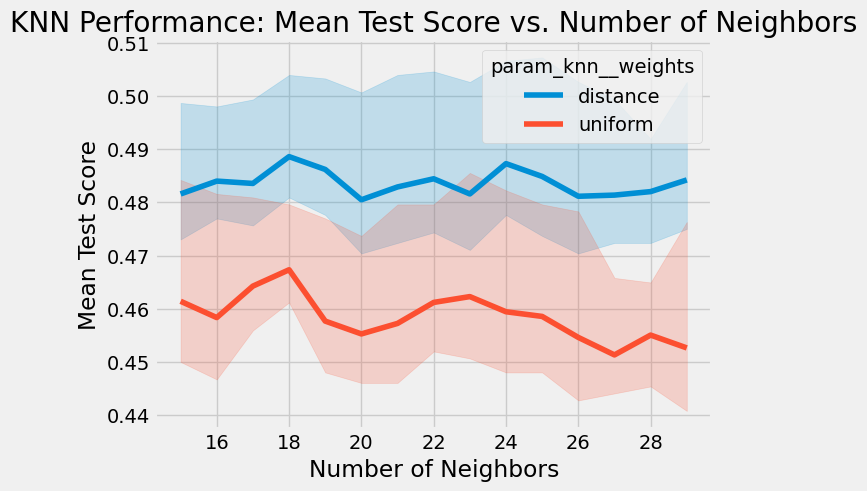

In [30]:
knn_vis = knn_results.groupby(by=['param_knn__n_neighbors', 'param_knn__weights']).mean_test_score.mean()
ax = sns.lineplot(data=knn_results, x='param_knn__n_neighbors', y='mean_test_score', hue='param_knn__weights')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Test Score')
plt.title('KNN Performance: Mean Test Score vs. Number of Neighbors')
plt.show()

In [22]:
knn_pred = knn_grid.predict(X_test)

# Inverse transform the labels to get their real names
y_test_real_names = genre_encoder.inverse_transform(y_test)
knn_pred_real_names = genre_encoder.inverse_transform(knn_pred)

# Print the classification report
report_str = classification_report(y_test_real_names, knn_pred_real_names)
for line in report_str.split('\n'):
    print(line)

              precision    recall  f1-score   support

     Country       0.29      0.40      0.33        35
      Cumbia       0.58      0.59      0.59        37
   Dancehall       0.43      0.46      0.45        28
 Death Metal       0.53      0.70      0.60        30
Experimental       0.48      0.32      0.38        38
       J-pop       0.35      0.48      0.41        31
   Quebecois       0.33      0.26      0.30        34
    Shoegaze       0.57      0.53      0.55        38
         Ska       0.36      0.29      0.32        35
      Techno       0.68      0.51      0.58        37

    accuracy                           0.45       343
   macro avg       0.46      0.45      0.45       343
weighted avg       0.46      0.45      0.45       343



Using this method, we achieved an accuracy of 60%, which means that our model performs significantly better than chance (with 10 genres, chance would be 10% accuracy).

Before we move onto trying other models, let's plot a confusion matrix to see if there are any particular places our model was tripped up.

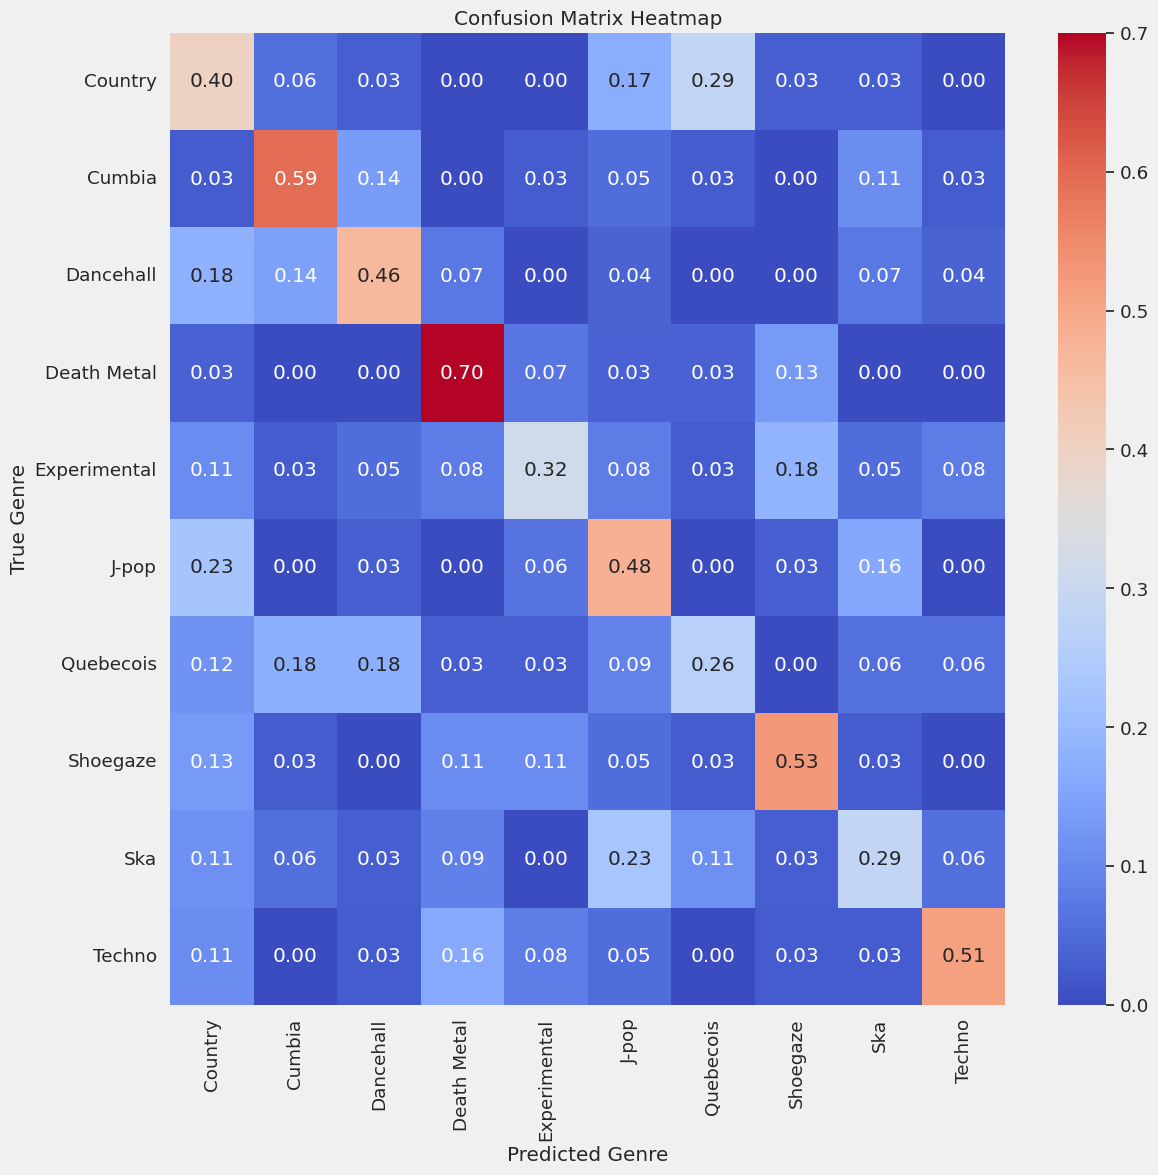

In [23]:
cm = confusion_matrix(y_test_real_names, knn_pred_real_names)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm_normalized, 
                 annot=True, 
                 cmap='coolwarm', 
                 fmt='.2f', 
                 xticklabels=genre_encoder.classes_, 
                 yticklabels=genre_encoder.classes_)

# Set labels and title
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Logistic Regression CV

Another option we can try is logistic regression. Because this method applies a regularization penalty to the different features in our dataset, it is useful for addressing colinearity between predictors. This is good in our case, because our features are mostly coorelated more strongly with each other than they are with our target (genre). 

We can reduce some of this noise by applying a disproportionate penalty to the largest coefficients (i.e. applying regulariazation). The LogisticRegressionCV class is particularly useful, because it uses K-Fold cross validation to test a variety of possible regularization penalty strenghts and selects the one that achieves the best results. 

In [ ]:
start = time.time()

lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(solver='liblinear',
                                                multi_class='auto', 
                                                max_iter=5000, 
                                                random_state=seed))
    ])

# Define the parameter grid for tuning
param_grid = {
    'scaler': [StandardScaler(), RobustScaler()],
    'logistic_regression__penalty': ['l1', 'l2'],
    'logistic_regression__C': np.logspace(-4, 4, 10)
}

# Use GridSearchCV to find the best combination of parameters
lr_grid = GridSearchCV(lr_pipe, param_grid, cv=5, scoring='accuracy')
lr_grid.fit(X_train_smote, y_train_smote)

# Print the best parameters and the corresponding score
print("Best parameters found: ", lr_grid.best_params_)
print("Best score found: ", lr_grid.best_score_)

test_score = lr_grid.score(X_test, y_test)
print("Test set score: ", test_score)

stop = time.time()
print('Time to run:', round(stop - start, 2))

In [ ]:
lr_results = pd.DataFrame(lr_grid.cv_results_)
lr_results.to_csv('lr_results.csv', index=False, encoding='utf-8')
lr_results.sort_values(by='mean_test_score', ascending=False).head(5)

In [ ]:
lr_vis = lr_results.groupby(by=['logistic_regression__C', 'logistic_regression__penalty']).mean_test_score.mean()
ax = sns.lineplot(data=lr_results, x='logistic_regression__C', y='mean_test_score', hue='logistic_regression__penalty')
plt.xlabel('C Value')
plt.ylabel('Mean Test Score')
plt.title('Logistic Regression Performance: Mean Test Score vs. C Value')
plt.show()

In [ ]:
lr_pred = lr_grid.predict(X_test)

lr_pred_real_names = genre_encoder.inverse_transform(lr_pred)

# Print the classification report
report_str = classification_report(y_test_real_names, lr_pred_real_names)
for line in report_str.split('\n'):
    print(line)

In [ ]:
cm = confusion_matrix(y_test_real_names, lr_pred_real_names)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm_normalized, 
                 annot=True, 
                 cmap='coolwarm', 
                 fmt='.2f', 
                 xticklabels=genre_encoder.classes_, 
                 yticklabels=genre_encoder.classes_)

# Set labels and title
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Random Forest Classifier

Next, let's try a decision tree-based model, which works by repeatedly finding the feature that most reduces class impurity, progressively creating smaller groups until a stopping point is reached.

In this case, we'll use a random forest, which is an ensemble method that trains a series of individual decision trees. Each tree is trained on a random subset of data and features, which helps reduce overfitting and volitility created by a particular set of input data.

A common rule of thumb for setting the maximum features to consider when making splits is that it should be the square root of the number of available features, which in this case is about 4. 

We'll also try some parameters to prevent overfitting, including max_depth, which limits the height of the binary decision tree min_samples_split, which limits how many samples can be used to make a split, and n_estimators, which is the number of underlying decision trees to train

In [5]:
start = time.time()

# Define the pipeline
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', RandomForestClassifier(random_state=seed,
                                          max_features='sqrt'
                                          ))
    ])

# Define the parameter grid
param_grid = {
    'scaler': [RobustScaler(), MaxAbsScaler()],
    'classifier__n_estimators': [125, 150, 175],
    'classifier__max_depth': [None, 30],
    'classifier__min_samples_split': [2, 10]
}

# Initialize the GridSearchCV
forest_grid = GridSearchCV(pipe, param_grid, cv=5)
forest_grid.fit(X_train_smote, y_train_smote)

# Print the best parameters and the corresponding score
print("Best parameters found: ", forest_grid.best_params_)
print("Best score found: ", forest_grid.best_score_)

# Predict using the best estimator
forest_pred = forest_grid.predict(X_test)

# Inverse transform the labels to get their real names
y_test_real_names = genre_encoder.inverse_transform(y_test)
forest_pred_real_names = genre_encoder.inverse_transform(forest_pred)

# Print the classification report
report_str = classification_report(y_test_real_names, forest_pred_real_names)
for line in report_str.split('\n'):
    print(line)

stop = time.time()
print('Time to run:', round(stop - start, 2))

NameError: name 'seed' is not defined

In [ ]:
forest_results = pd.DataFrame(forest_grid.cv_results_)
forest_results.to_csv('forest_results.csv', index=False, encoding='utf-8')
forest_results.sort_values(by='mean_test_score', ascending=False).head(5)

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_real_names, forest_pred_real_names)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm_normalized, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=genre_encoder.classes_, yticklabels=genre_encoder.classes_)

# Set labels and title
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
importances = forest_grid.best_estimator_.named_steps['classifier'].feature_importances_
feature_names = X_train.columns

feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

FEATURES_TO_DISPLAY = 30

# Sort the DataFrame by importance in descending order
sorted_feature_importances = feature_importances.sort_values('importance', ascending=False)[:FEATURES_TO_DISPLAY]

# Plot the feature importances
plt.figure(figsize=(10, 5))
plt.bar(sorted_feature_importances['feature'], sorted_feature_importances['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in RandomForestClassifier')
plt.xticks(rotation=90)
plt.show()


## XGBoost

In [ ]:
start = time.time() 

# Create a pipeline with StandardScaler and XGBClassifier
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', xgb.XGBClassifier(random_state=seed, 
                                     max_depth=5,
                                     learning_rate=.1
                                     ))
])

# Define the parameter search space for GridSearchCV
param_grid = {
    'scaler': [StandardScaler(), RobustScaler()],
    'classifier__n_estimators': [100, 150]
}

# Initialize the GridSearchCV
xgb_grid = GridSearchCV(pipe, param_grid, cv=5)
xgb_grid.fit(X_train_smote, y_train_smote)

# Print the best parameters and the corresponding score
print("Best parameters found: ", xgb_grid.best_params_)
print("Best score found: ", xgb_grid.best_score_)

# Predict using the best estimator
xgb_pred = xgb_grid.predict(X_test)

# Inverse transform the labels to get their real names
xgb_pred_real_names = genre_encoder.inverse_transform(xgb_pred)

# Print the classification report
report_str = classification_report(y_test_real_names, xgb_pred_real_names)
for line in report_str.split('\n'):
    print(line)

stop = time.time()
print('Time to run:', round(stop - start, 2))


In [ ]:
xgb_results = pd.DataFrame(xgb_grid.cv_results_)
xgb_results.to_csv('xgb_results.csv', index=False, encoding='utf-8')
xgb_results.sort_values(by='mean_test_score', ascending=False).head(5)

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_real_names, xgb_pred_real_names)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm_normalized, 
                 annot=True, 
                 cmap='coolwarm', 
                 fmt='.2f', 
                 xticklabels=genre_encoder.classes_, 
                 yticklabels=genre_encoder.classes_)

# Set labels and title
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
importances = xgb_grid.best_estimator_.named_steps['classifier'].feature_importances_
feature_names = X_train.columns

feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

FEATURES_TO_DISPLAY = 40

# Sort the DataFrame by importance in descending order
sorted_feature_importances = feature_importances.sort_values('importance', ascending=False)[:FEATURES_TO_DISPLAY]

# Plot the feature importances
plt.figure(figsize=(10, 5))
plt.bar(sorted_feature_importances['feature'], sorted_feature_importances['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in XGBoost')
plt.xticks(rotation=90)
plt.show()